In [1]:
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr

In [4]:
file_paths = glob.glob("csv_results/*_sample_fraction*.csv")
sorted(file_paths)

['csv_results/age_sample_fraction_0.05.csv',
 'csv_results/age_sample_fraction_0.287.csv',
 'csv_results/age_sample_fraction_0.525.csv',
 'csv_results/gender_sample_fraction_0.05.csv',
 'csv_results/gender_sample_fraction_0.287.csv',
 'csv_results/gender_sample_fraction_0.525.csv',
 'csv_results/gender_sample_fraction_0.762.csv',
 'csv_results/gender_sample_fraction_1.csv',
 'csv_results/rosbank_sample_fraction_0.05.csv',
 'csv_results/rosbank_sample_fraction_0.287.csv',
 'csv_results/rosbank_sample_fraction_0.525.csv',
 'csv_results/rosbank_sample_fraction_0.762.csv',
 'csv_results/rosbank_sample_fraction_1.csv']

In [9]:
import re

rosbank_files = glob.glob("csv_results/rosbank_sample_fraction*.csv")

for path in rosbank_files:
    match = re.search(r"sample_fraction_([0-9.]+).csv", path)
    if not match:
        print(f"Не удалось извлечь sample_fraction из {path}")
        continue
    print(match)
    print(match.group(1))

    sample_fraction = float(match.group(1))
    df = pd.read_csv(path)
    df['sample_fraction'] = sample_fraction
    df.to_csv(path, index=False)

<re.Match object; span=(20, 45), match='sample_fraction_0.287.csv'>
0.287
<re.Match object; span=(20, 44), match='sample_fraction_0.05.csv'>
0.05
<re.Match object; span=(20, 45), match='sample_fraction_0.525.csv'>
0.525
<re.Match object; span=(20, 41), match='sample_fraction_1.csv'>
1
<re.Match object; span=(20, 45), match='sample_fraction_0.762.csv'>
0.762


In [10]:
all_data = []
for path in file_paths:
    df = pd.read_csv(path)
    task_type = os.path.basename(path).split('_')[0]  # age, gender, rosbank
    df['task'] = task_type
    all_data.append(df)

df_all = pd.concat(all_data, ignore_index=True)

In [11]:
metric_columns = [col for col in df_all.columns if col.startswith("metric_")]
results = []

# Считаем корреляции Spearman'а метрик с accuracy для каждого sample_fraction и task
for (task, sample_fraction), group in df_all.groupby(['task', 'sample_fraction']):
    for metric in metric_columns:
        if group[metric].nunique() > 1:
            corr, _ = spearmanr(group[metric], group['accuracy'])
            results.append({
                'task': task,
                'sample_fraction': sample_fraction,
                'metric': metric,
                'correlation': corr
            })

# В датафрейм с результатами
df_corr = pd.DataFrame(results)

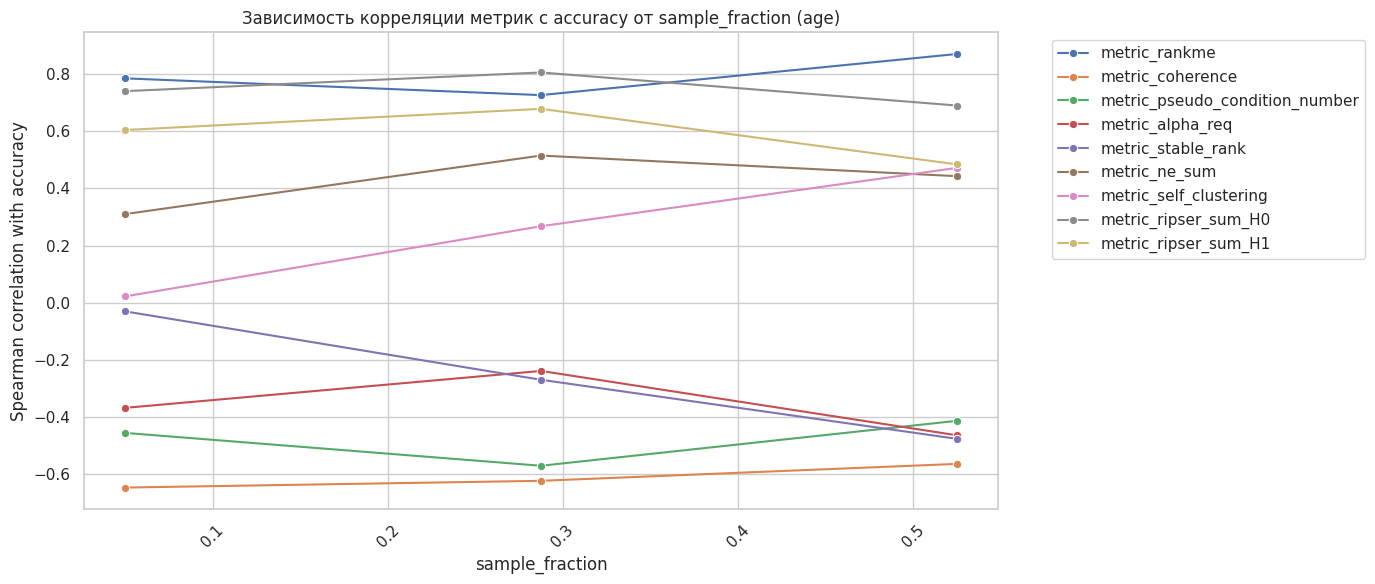

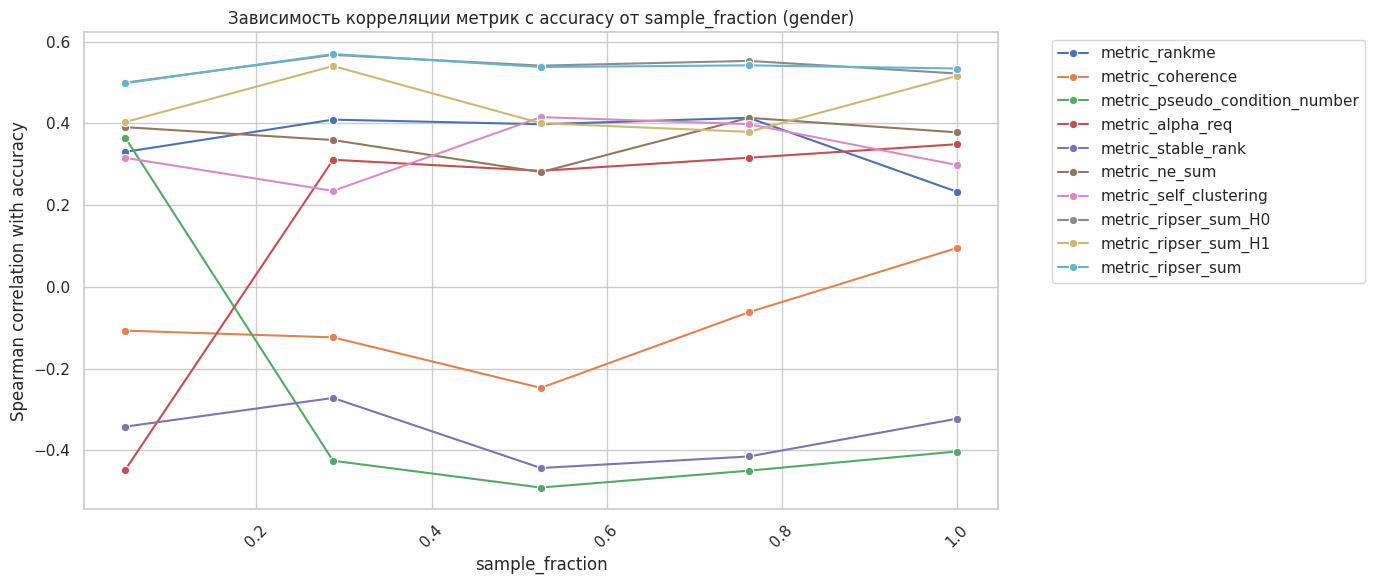

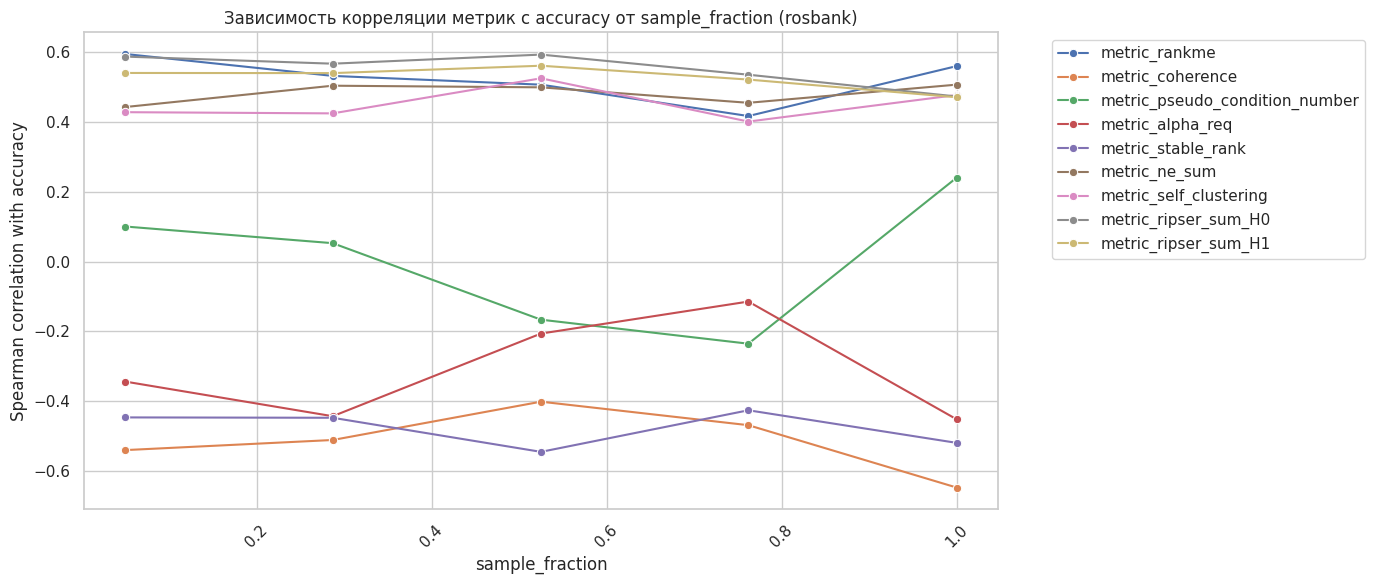

In [12]:
sns.set(style="whitegrid")
for task in df_corr['task'].unique():
    plt.figure(figsize=(14, 6))
    sns.lineplot(data=df_corr[df_corr['task'] == task],
                 x='sample_fraction', y='correlation', hue='metric', marker="o")
    plt.title(f"Зависимость корреляции метрик с accuracy от sample_fraction ({task})")
    plt.ylabel("Spearman correlation with accuracy")
    plt.xlabel("sample_fraction")
    plt.xticks(rotation=45)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


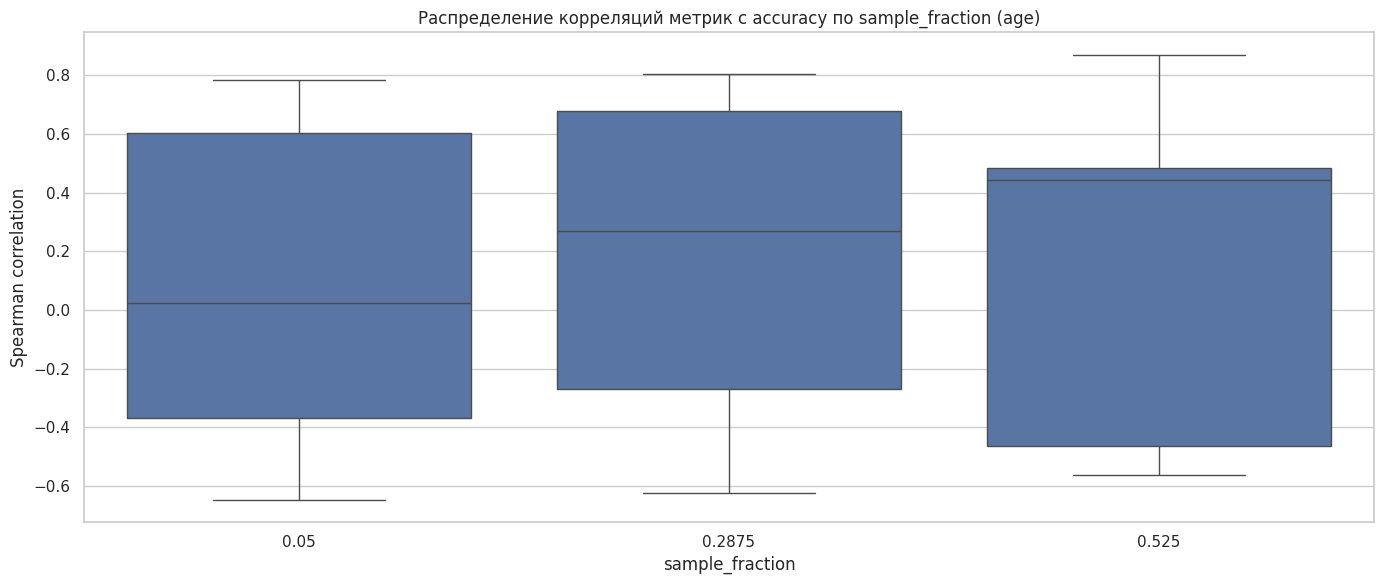

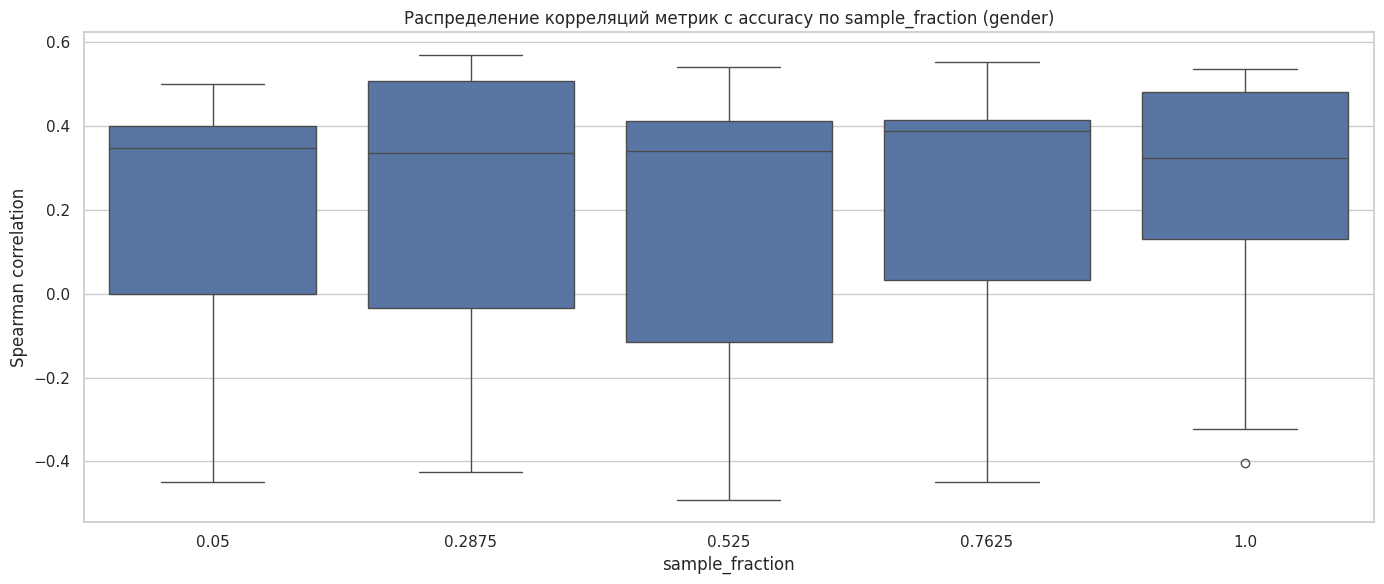

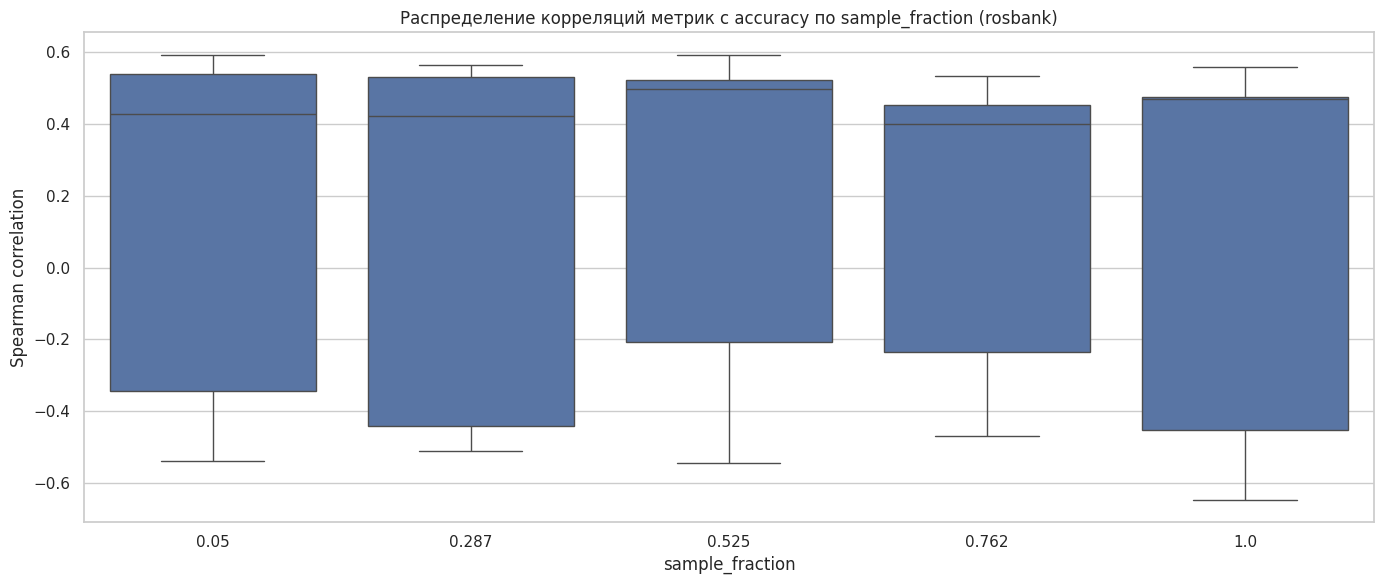

In [13]:
for task in df_corr['task'].unique():
    plt.figure(figsize=(14, 6))
    sns.boxplot(data=df_corr[df_corr['task'] == task],
                x='sample_fraction', y='correlation')
    plt.title(f"Распределение корреляций метрик с accuracy по sample_fraction ({task})")
    plt.ylabel("Spearman correlation")
    plt.xlabel("sample_fraction")
    plt.tight_layout()
    plt.show()

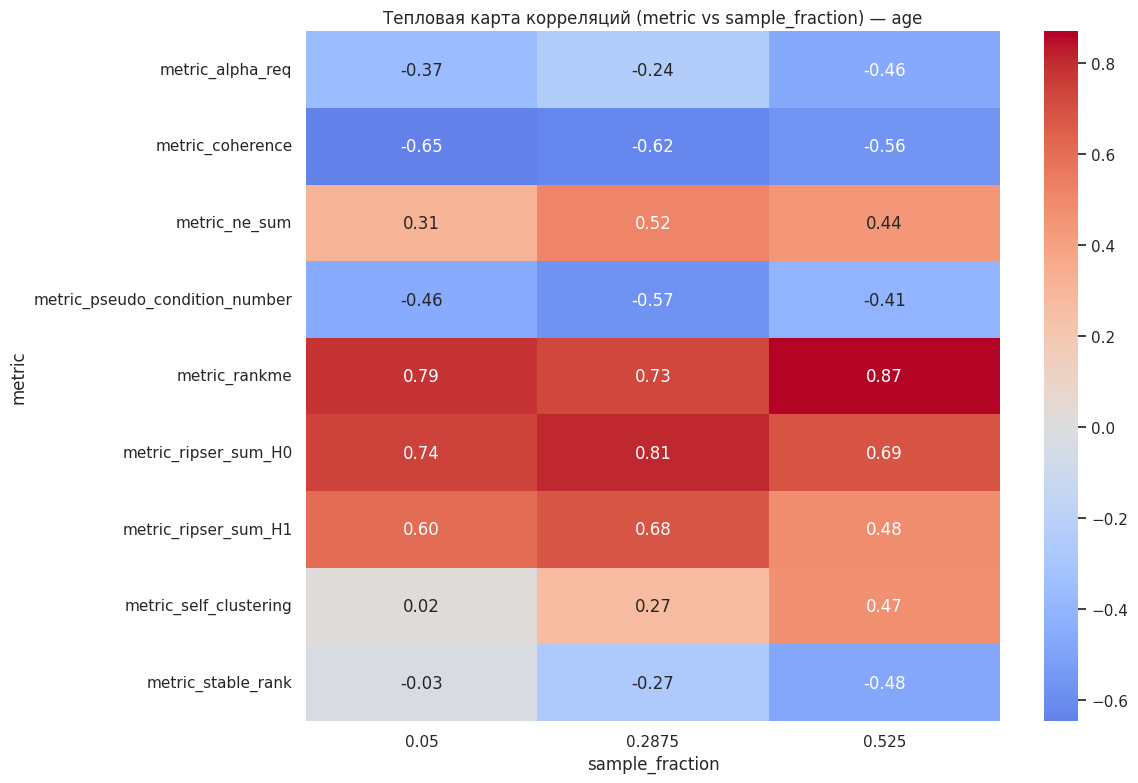

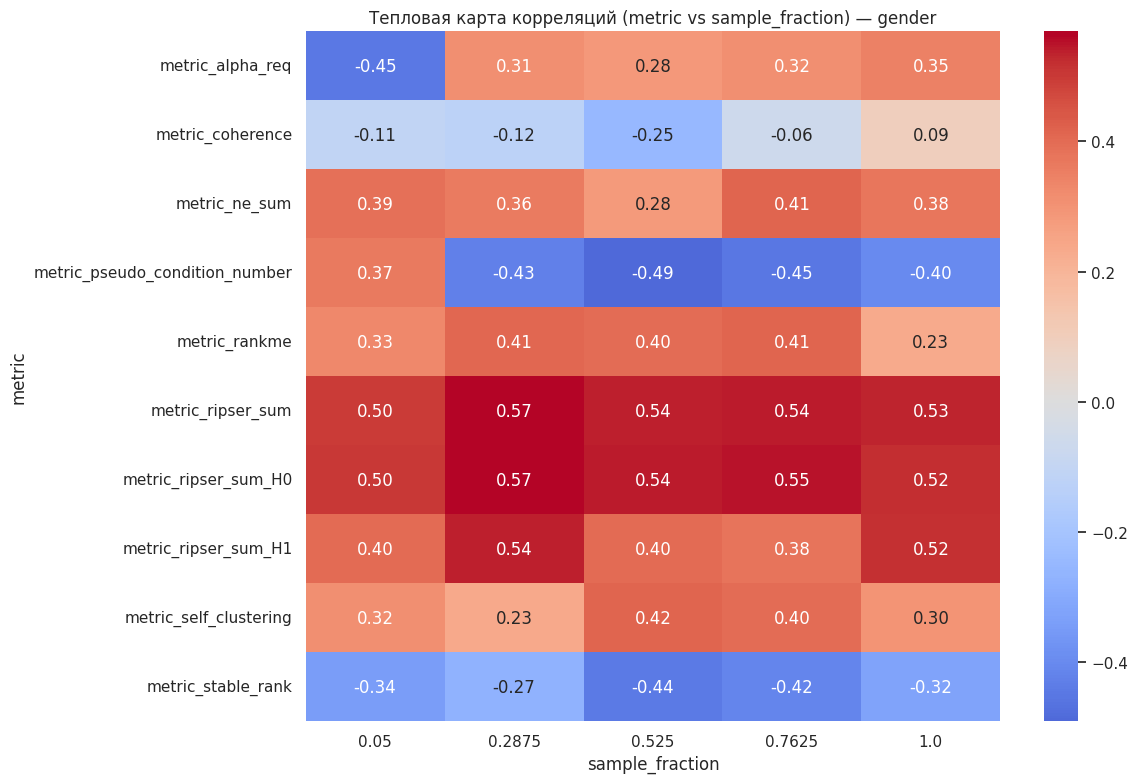

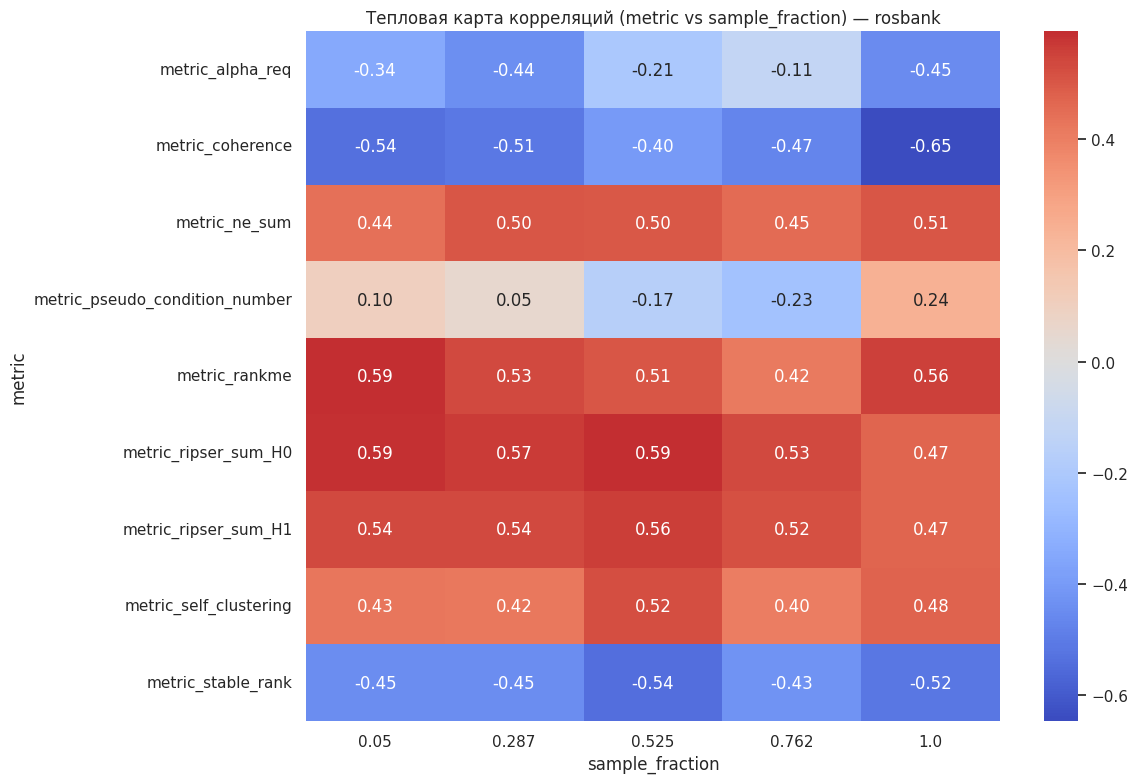

In [14]:
for task in df_corr['task'].unique():
    pivot = df_corr[df_corr['task'] == task].pivot(index='metric', columns='sample_fraction', values='correlation')
    plt.figure(figsize=(12, 8))
    sns.heatmap(pivot, annot=True, fmt=".2f", cmap='coolwarm', center=0)
    plt.title(f"Тепловая карта корреляций (metric vs sample_fraction) — {task}")
    plt.xlabel("sample_fraction")
    plt.ylabel("metric")
    plt.tight_layout()
    plt.show()

In [31]:
from sklearn.preprocessing import StandardScaler

df_all_scaled = pd.DataFrame()
for task in df_all['task'].unique():
    task_df = df_all[df_all['task'] == task].copy()
    scaler = StandardScaler()
    task_df[metric_columns] = scaler.fit_transform(task_df[metric_columns])
    df_all_scaled = pd.concat([df_all_scaled, task_df], ignore_index=True)

# Считаем корреляции метрик с accuracy по каждому sample_fraction
correlations = []

for (task, sample_fraction), group in df_all_scaled.groupby(['task', 'sample_fraction']):
    for metric in metric_columns:
        if group[metric].nunique() > 1:
            corr, _ = spearmanr(group[metric], group['accuracy'])
            correlations.append({
                'task': task,
                'sample_fraction': sample_fraction,
                'metric': metric,
                'correlation': corr
            })

df_corr = pd.DataFrame(correlations)

# Теперь считаем std корреляций по sample_fraction
std_corr_results = (
    df_corr.groupby(['task', 'metric'])['correlation']
    .std()
    .reset_index()
    .rename(columns={'correlation': 'std_correlation_across_sample_fraction'})
)

/home/dpetrovitch/venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:1101: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/home/dpetrovitch/venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:1106: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/home/dpetrovitch/venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:1126: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
/home/dpetrovitch/venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:1101: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/home/dpetrovitch/venv/lib/python3.12/site-packages/sklearn/utils/extmath.py:1106: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/home/dpetrovitch/venv/lib/python3.12/site-packages/sklearn/utils/extmath

In [33]:
std_corr_results.sort_values(by=['task', 'std_correlation_across_sample_fraction'])

,task,metric,std_correlation_across_sample_fraction
1,age,metric_coherence,0.042641
5,age,metric_ripser_sum_H0,0.057979
4,age,metric_rankme,0.072323
3,age,metric_pseudo_condition_number,0.081337
6,age,metric_ripser_sum_H1,0.098099
2,age,metric_ne_sum,0.103868
0,age,metric_alpha_req,0.112968
8,age,metric_stable_rank,0.223172
7,age,metric_self_clustering,0.225147
14,gender,metric_ripser_sum,0.025517
